<a href="https://colab.research.google.com/github/gayangana/EN4553_Assignments/blob/main/Assignment_1_170344X.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EN4353 - Radar and Navigation**
# **Assignment 1**

I.U.G.Leelarathne - 170344X

Editable Link to Google Colab Notebook :  https://colab.research.google.com/drive/12kxQ3NZU3XB-WprVmJWnNbCqLDSveiEs?usp=sharing



# **Radar Description**
   
* Raw Video Sampling Rate $(f_s) = 1080\ kHz$
* Pulse Repetition Frequency $(f_r) = 1800\ Hz$
* Horizontal Beam Width $(θ_H) = 2^0$
* Radar Rotation Speed $(RPM) = 12\ RPM$
* Noise Variance $(σ_n) = 1$


# **Upload Files**

If it is necessary to upload a file and use it as a test case, uncomment the next cell and upload the required files. Otherwise, dataset can be imported by giving the url from the proceeding cells

In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [ ]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
raw_data1 = "https://raw.githubusercontent.com/gayangana/EN4553_Assignments/04e857168d96ace8800d844cd7a66107c32c5ee8/Assignment_1/Datasets/raw_data1.csv"
raw_data2 = "https://raw.githubusercontent.com/gayangana/EN4553_Assignments/04e857168d96ace8800d844cd7a66107c32c5ee8/Assignment_1/Datasets/raw_data2.csv"
raw_data3 = "https://raw.githubusercontent.com/gayangana/EN4553_Assignments/04e857168d96ace8800d844cd7a66107c32c5ee8/Assignment_1/Datasets/raw_data3.csv"


# **Load Dataset**
Change the variable `dataset_path` to select the file containing data

In [ ]:
#Read data
#Change the variable dataset_path to either uploaded file name or dataset url
dataset_path = raw_data3

data = pd.read_csv(dataset_path,header=None)
data_arr = np.array((data.iloc[:,0]))


# **Downsampling**
Given dataset is sampled at $1080\ kHz$ and it is given that the Number of Range slots are $30$. Initially, we need to calculate the required sampling frequency to have $30$ range slots.
<br>
<br>
Downsampled Sampling Frequency = $f_{sd}$

$f_{sd}\ =\ Nf_r$<br>
$f_{sd}\ =\ 30*1800\ =\ 54\ kHz$

Downsampling factor = $\frac{1080}{54}\ =\ 20$
<br>
<br>

# **Number of Echoes**

Number of echoes per target per sweep = $\frac{θ_H f_r}{6*RPM} =\ \frac{2*1800}{6*12}\ =\ 50\ echoes $ 
<br>
<br>  

Sampling Time = $\ T_s $<br>
Angle Rotated =$\ θ_r$

$T_s = \frac{18000}{1080000}\ = \frac{1}{60} s$ 

$θ_r =\frac{RPM* T_s *360}{60}\ = \frac{12*360}{60*60}\ =\ 1.2^0$  

Number of echoes for angle rotated ($1.2^0$) = $\frac{1.2*50}{2}\ =\ 3 0$
<br>
<br>

Therefore shape of the Data Matrix is,
<br>

(Number of pulses, Number of Range Slots) =$\ (30,30)$ 
<br>
<br>

# **Noise Thresholding**

Calculating average noise corresponding to each sample is carried out on original samples (sampled at $1080\ kHz$) with a window size of $21$ and a guard band of $4$. Then, noise threshold for each sample is calcaulted using the equation given below.

$V_{th} =\ (V_n)_{avg}\ +\ k*σ_n$

Here I have selected $k\ =\ 1.5$

After calculating noise threshold for each sample (sampled at $1080\ kHz$), data stream is downsampled to $54\ kHz$. This is done by selecting every $20^{th}$ sample with corresponding noise threshold for that sample from the data stream.

Downsampled data stream is arranged as a (Number of pulses * Number of Range Slots) matrix.

In [ ]:
#Define Parameters

#Determined
k = 1.5
sigma_n = 1
N_range_slots = 30

#Calculated
downsample_factor = 20
N_pulses = 30


In [ ]:
#Function to calculate noise threshold for 1080kHz data samples
def noise_threshold(data_arr,k,sigma_n):
    Vn_avg_arr=np.zeros(data_arr.shape)

    for i in range(data_arr.shape[0]):
        past_window = data_arr[max(0,i-10):max(0,i-4)]
        future_window = data_arr[min(i+5,data_arr.shape[0]):min(i+11,data_arr.shape[0])]

        Vn_avg_arr[i] = (np.sum(past_window)+np.sum(future_window))/(past_window.shape[0]+future_window.shape[0])

    Vth_arr = Vn_avg_arr + k*sigma_n
    
    return Vth_arr
    
Vth_arr = noise_threshold(data_arr,k,sigma_n)

data_updated = pd.concat([data,pd.Series(Vth_arr)],axis = 'columns')
data_updated.columns =['V_Rx','V_th']
data_updated.head()

,V_Rx,V_th
0,2.238215,1.525952
1,0.199574,1.380146
2,0.106171,0.846108
3,2.253664,1.231221
4,0.124181,1.192814


In [ ]:
#Function to downsample the data
def downsample(df,downsample_factor):
    return df.iloc[::downsample_factor, :]

data_downsampled = downsample(data_updated,downsample_factor)
data_downsampled.columns =['V_Rx','V_th']
data_downsampled.to_csv('downsampled.csv',index=False)

data_downsampled.head()

,V_Rx,V_th
0,2.238215,1.525952
20,1.331946,1.146475
40,-0.524648,1.543311
60,-0.304372,2.377522
80,8.503225,6.830342


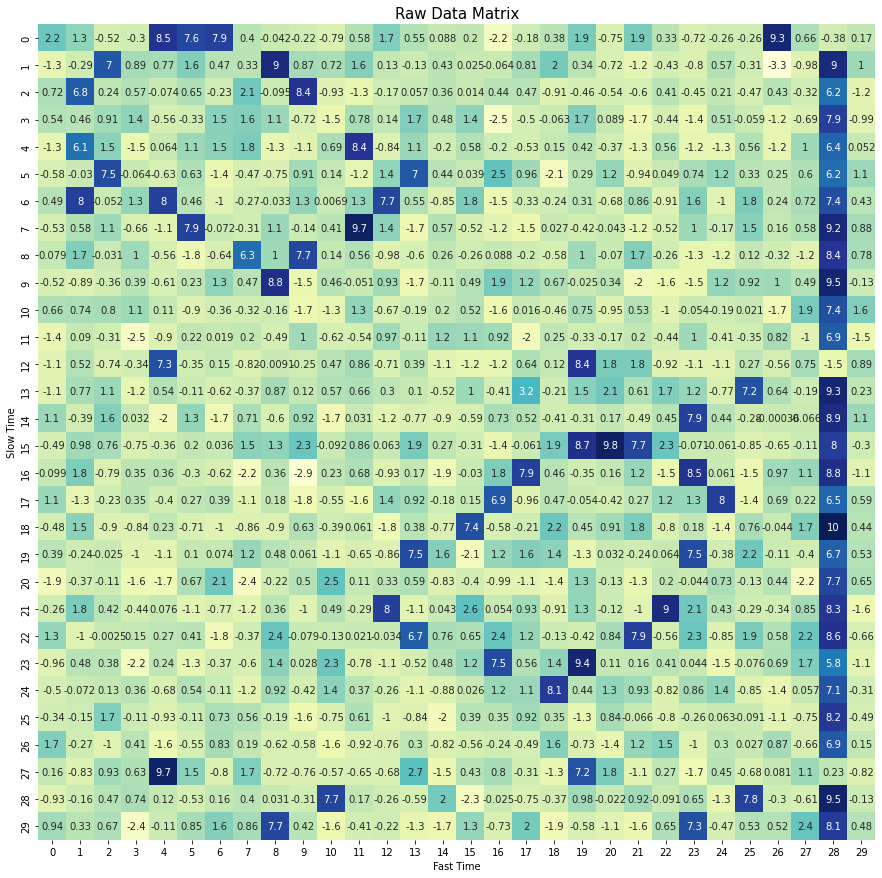

In [ ]:
#Plot downsampled raw data matrix
raw_data_matrix=np.array(data_downsampled)[:,0].reshape(N_pulses,N_range_slots)

plt.figure(figsize=(15,15))
sns.heatmap(raw_data_matrix, annot=True, cbar=False, cmap="YlGnBu")
plt.title("Raw Data Matrix", fontsize= 15)
plt.xlabel("Fast Time") 
plt.ylabel('Slow Time')
plt.show()
    

# **Object Detection**


Object detection is carried out using the follwing algorithm. 

If the received sample $(V_{Rx})$ is greater than noise threshold $(V_{th})$ for that bin, then it is considered as a potential object. Otherwise it is not considered as an object. i.e. 

* If an object is present     : $V_k\ =\ 1$
* If an object is not present : $V_k\ =\ 0$

Algorithm:
* If $V_{Rx}\ >\ V_{th} =>\ V_k\ =\ 1 $
* If $V_{Rx}\ ≤\ V_{th} =>\ V_k\ =\ 0 $

After that $V_k$ column is analyzed using *Non Coherant Binary Intergration*. If there is at least possible 15 objects detected for a particular range slot, then it is considered as a object. Otherwise it is not considered as an object. Objects are encoded with 0.5 in the data matrix.

In the presence of a object, we need to store the first pulse where the object is detected ($n$) and the last pulse where the object is detected ($m$). $n$ and $m$ values are stored to calculate the azimuth angle of the object.

In [ ]:
#Noise thresholding 
data_downsampled['V_k']=np.where(np.array(data_downsampled['V_Rx'])>np.array(data_downsampled['V_th']),1,0)
data_downsampled.head()

,V_Rx,V_th,V_k
0,2.238215,1.525952,1
20,1.331946,1.146475,1
40,-0.524648,1.543311,0
60,-0.304372,2.377522,0
80,8.503225,6.830342,1


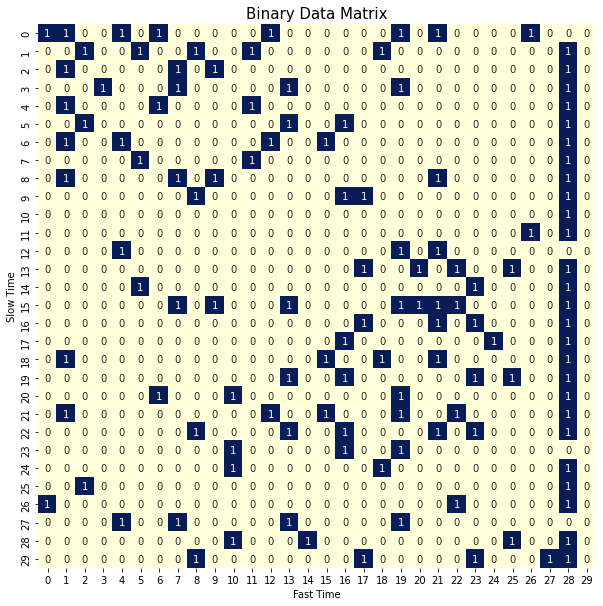

In [ ]:
#Data matrix after potential object detection
binary_data_matrix=np.array(data_downsampled)[:,2].reshape(N_pulses,N_range_slots)

plt.figure(figsize=(10,10))
sns.heatmap(binary_data_matrix, annot=True, cbar=False, cmap="YlGnBu")
plt.title("Binary Data Matrix", fontsize= 15)
plt.xlabel("Fast Time") 
plt.ylabel('Slow Time')
plt.show()

In [ ]:
#Function to store first pulse(n) and the last pulse(m) to detect the target
def calc_n_m(List):
  for j in range(len(List)):
    if ((List[j])==1):
      n=j+1
      break
  inv_list =List[::-1]
  for k in range(len(List)):
    if (inv_list[j]==1):
      m=29-k+1
      break
  return n,m

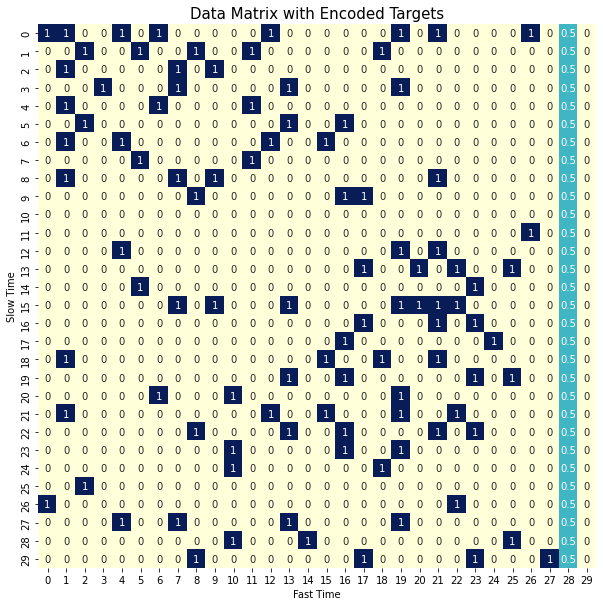

In [ ]:
#Object Detection

targets = []
n_vals = []
m_vals = []
Sum = binary_data_matrix.sum(axis=0)

for i in range(Sum.shape[0]):
    if Sum[i]>15:
        target_vals=list(binary_data_matrix[:,i])
        n,m =calc_n_m(target_vals)
        n_vals.append(n)
        m_vals.append(m)
        binary_data_matrix[:,i]=0.5
        targets.append(1)
    else:
        targets.append(0)
        
target_loc = [i for i in range(len(targets)) if targets[i]==1]
#print(",".join(str(v) for v in target_loc))



plt.figure(figsize=(10,10))
sns.heatmap(binary_data_matrix, annot=True, cbar=False, cmap="YlGnBu")
plt.title("Data Matrix with Encoded Targets", fontsize= 15)
plt.xlabel("Fast Time") 
plt.ylabel('Slow Time')
plt.show()
    

# **Cloud Detection Algorithm**

The result obtained from noise thresholding procedure is noisy and there can be outliers. To filter noise and outliers, follwing steps are followed.

1. Sample Thresholding
2. Convolution with filters

## **Sample Thresholding**

`raw_data_matrix` includes the samples. By observing the samples, we can see that the amplitude of clouds and objects are comparatively high when we compare with other samples. In sample thresholding, from the originally identified objects ($V_k=1$), we filter out the samples that have lower amplitude than the threshold. From this method we can filter out unnecessary samples that are detected as objects.

New Objects =  $V_{k,th}$<br>
Threshold   =  $t$

* If $V_k\ =\ 1$ and $V_{Rx}\ >\ t\ => V_{k,th}\ =\ 1$
* If  $V_k\ =\ 1$ and $V_{Rx}\ <\ t\ => V_{k,th}\ =\ 0$
* If $V_k\ =\ 0\ =>\ V_{k,th}\ =\ 0$ 

## **Convolution with Filters**
Shape of the filter is $f$ and only odd integers are considered for $f$,

Convolution kernels are traversed through columns and rows of binary data matrix with a stride of 1 to filter out the noise. In the presence of an object inside the kernel (when $V_{k,th}$ of the centre index of the kernel is equal to one), If the summation of values inside the kernel are less than or equal to the threshold, $V_{k,th}$ of the centre index is changed to $0$.

<img src="https://raw.githubusercontent.com/gayangana/EN4553_Assignments/a13fbfd757d68f5265d8ae50191f3293132c6be6/Assignment_1/Images/kernal.PNG" width="400" height="150">


if $V_{k,th}\ of\ [Kernel[i,j]] =1$ and  $ \sum_{p,q\ ϵ\ kernel} V_{k,th}\ of\ [Kernel[p,q]]\ \le \ threshold\  =>\ V_{k,th}\ of\ [Kernel[i,j]] =0$

One of the issue in using convolution filters is the inability traverse in the indces closer to the edge. Therefore, before applying a convolution filter, data matrix is zero padded with $p$ number of rows and columns to carry out convolution through all the indices in the matrix. 

$p = \frac{f-1}{2}$

<!-- ![](https://raw.githubusercontent.com/gayangana/EN4553_Assignments/a13fbfd757d68f5265d8ae50191f3293132c6be6/Assignment_1/Images/kernal.PNG) -->



After applying the filter, zero padded rows and columns are removed.

## **Algorithm**
1. Sample Thresholding with a threshold of 5
2. Convolution with a 7x7 filter with a threshold of 2
3. Convolution with a 5x5 filter with a threshold of 1

Additionally, result is convoluted with 3x3 filter with a threshold of 1 after filling the clouds to filter out any unfiltered noise or outliers.

Objects detected through non coherant binary integration are not considered when applying convolution filter. Instead, $V_{k,th}$ of those indices are assigned to be zero to make convolution easier.  


In [ ]:
#Sample Thresholding with a threshold of 5

V_k_th = np.zeros((data_downsampled.shape[0],1))

for i in range (data_downsampled.shape[0]):
    if ((data_downsampled.iloc[i,0]>5) and (data_downsampled.iloc[i,2]==1)):
        V_k_th[i] = 1

data_downsampled['V_k_th'] = V_k_th
data_downsampled.head(10)

,V_Rx,V_th,V_k,V_k_th
0,2.238215,1.525952,1,0.0
20,1.331946,1.146475,1,0.0
40,-0.524648,1.543311,0,0.0
60,-0.304372,2.377522,0,0.0
80,8.503225,6.830342,1,1.0
100,7.629286,7.754759,0,0.0
120,7.917546,7.007533,1,1.0
140,0.396035,2.128088,0,0.0
160,-0.042297,1.420717,0,0.0
180,-0.220216,1.453804,0,0.0


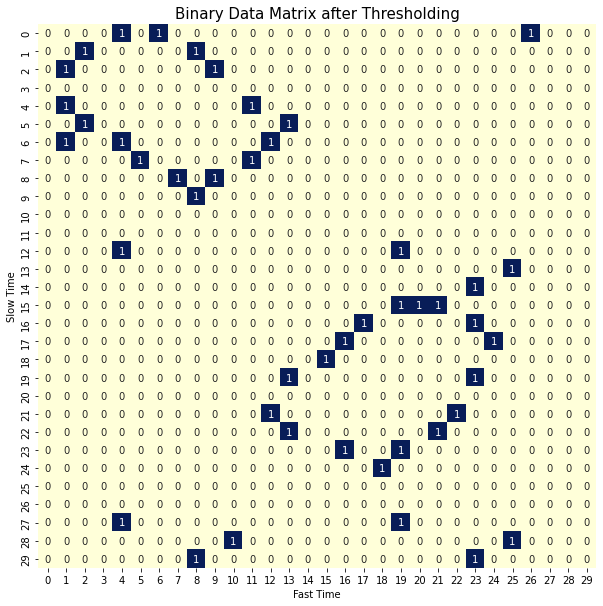

In [ ]:
#Assigning 0 to locations where objects were detected from coherant integration
th_binary_data_matrix=np.array(data_downsampled)[:,3].reshape(30,30)

for i in range(len(targets)):
    if (targets[i]==1):
        th_binary_data_matrix[:,i]=0

plt.figure(figsize=(10,10))
sns.heatmap(th_binary_data_matrix, annot=True, cbar=False, cmap="YlGnBu")
plt.title("Binary Data Matrix after Thresholding", fontsize= 15)
plt.xlabel("Fast Time") 
plt.ylabel('Slow Time')
plt.show()

In [ ]:
#Function to add padding before applying noise filters
def add_padding(matrix, padding):
    n, m = matrix.shape
    p = padding
    
    padded_matrix = np.zeros((n + p * 2, m + p * 2))
    padded_matrix[p : n + p, p : m + p] = matrix
    
    return padded_matrix

In [ ]:
#Function to perform convolution with filters

def noise_filter(matrix,filter_size,threshold):
    margin = filter_size//2
    p = int((filter_size-1)/2)
    matrix = add_padding(matrix,p)

    for i in range(margin,matrix.shape[1]-margin):
        for j in range(margin,matrix.shape[0]-margin):
            sub_mat = np.array(matrix)[i-margin:i+margin+1,j-margin:j+margin+1]
            if (np.sum(sub_mat)<=threshold):
                matrix[i,j] = 0
            
    matrix = matrix[p:matrix.shape[0]-p,p:matrix.shape[0]-p]
    return matrix


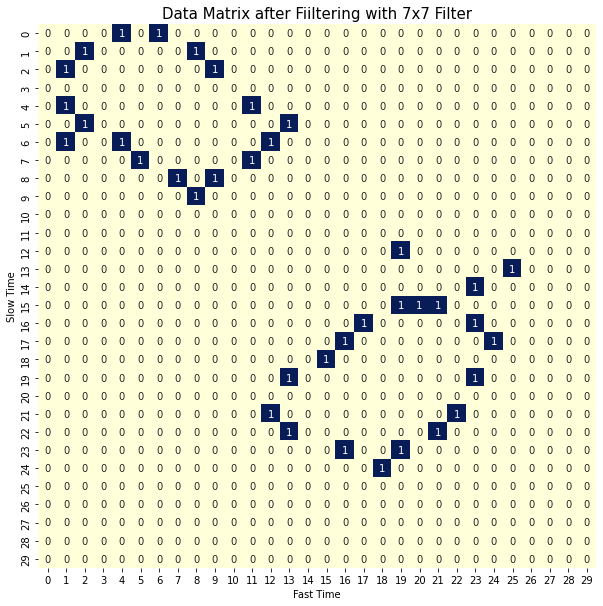

In [ ]:
#Filtering with 7x7 filter with a threshold of 2
noise_filtered_1 = noise_filter(th_binary_data_matrix,7,2)

plt.figure(figsize=(10,10))
sns.heatmap(noise_filtered_1, annot=True, cbar=False, cmap="YlGnBu")
plt.title("Data Matrix after Fiiltering with 7x7 Filter", fontsize= 15)
plt.xlabel("Fast Time") 
plt.ylabel('Slow Time')
plt.show()

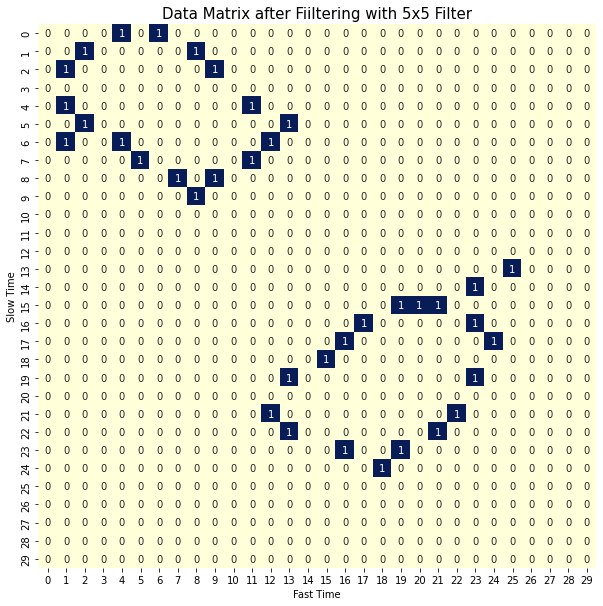

In [ ]:
#Filtering with 5x5 filter with a threshold of 1
noise_filtered_2 = noise_filter(noise_filtered_1,5,1)

plt.figure(figsize=(10,10))
sns.heatmap(noise_filtered_2, annot=True, cbar=False, cmap="YlGnBu")
plt.title("Data Matrix after Fiiltering with 5x5 Filter", fontsize= 15)
plt.xlabel("Fast Time") 
plt.ylabel('Slow Time')
plt.show()

# **Contour Completion**

By analyzing the filtered image, we can see that there are scenarios where we need to fill the missing locations to complete the contour of the clound. Contour completion has two stages.

1. Identification of locations that require to fill 2 locations and filling them. There can be 12 such scnearios and the contour is completed preserving the shape of the cloud.

![](https://raw.githubusercontent.com/gayangana/EN4553_Assignments/1450d5301f4cb8ac5a13021d06cb9fd977a44bf4/Assignment_1/Images/fill_2_loc.PNG)

2. Identification of locations that require to fill 1 location and filling them. There can be 8 such instances and contour is completed preserving the shape of the cloud.

![](https://raw.githubusercontent.com/gayangana/EN4553_Assignments/1450d5301f4cb8ac5a13021d06cb9fd977a44bf4/Assignment_1/Images/fill_1_loc.PNG)




In [ ]:
#Function to fill two boxes to complete the contour
#Newly filled values can be indicated with a different value
def fill_2_loc(matrix,t):
    for i in range(0,matrix.shape[0]-3):
        for j in range (0,matrix.shape[1]-3):
            #case 1
            if ((matrix[i,j] == 1) and (matrix[i,j+3]==1)):
                matrix[i,j+1]=t
                matrix[i,j+2]=t
            
            #case 2
            elif ((matrix[i,j] == 1) and (matrix[i+1,j+3]==1)):
                matrix[i,j+1]=t
                matrix[i+1,j+2]=t
            
            #case 3
            elif ((matrix[i,j] == 1) and (matrix[i+2,j+3]==1)):
                matrix[i+1,j+1]=t
                matrix[i+1,j+2]=t
            
            #case 4
            elif ((matrix[i,j] == 1) and (matrix[i+3,j+3]==1)):
                matrix[i+1,j+1]=t
                matrix[i+2,j+2]=t
                
            #case 5
            elif ((matrix[i+1,j] == 1) and (matrix[i,j+3]==1)):
                matrix[i+1,j+1]=t
                matrix[i,j+2]=t
                
            #case 6
            elif ((matrix[i+2,j] == 1) and (matrix[i,j+3]==1)):
                matrix[i+1,j+1]=t
                matrix[i+1,j+2]=t
            
            #case 7
            elif ((matrix[i,j+3] == 1) and (matrix[i+3,j]==1)):
                matrix[i+1,j+2]=t
                matrix[i+2,j+1]=t
                
            #case 8
            elif ((matrix[i,j+1] == 1) and (matrix[i+3,j]==1)):
                matrix[i+1,j+1]=t
                matrix[i+2,j]=t
                
            #case 9
            elif ((matrix[i,j] == 1) and (matrix[i+3,j]==1)):
                matrix[i+1,j]=t
                matrix[i+2,j]=t
            
            #case 10
            elif ((matrix[i,j] == 1) and (matrix[i+3,j+1]==1)):
                matrix[i+1,j]=t
                matrix[i+2,j+1]=t   
                
            #case 11
            elif ((matrix[i,j] == 1) and (matrix[i+3,j+2]==1)):
                matrix[i+1,j+1]=t
                matrix[i+2,j+1]=t
            
            #case 12
            elif ((matrix[i,j+2] == 1) and (matrix[i+3,j]==1)):
                matrix[i+1,j+1]=t
                matrix[i+2,j+1]=t              
    return matrix


In [ ]:
#Function to fill 1 box to complete the contour
#Newly filled values are indicated with a different value
def fill_1_loc(matrix,t):
    for i in range(0,matrix.shape[0]-2):
        for j in range (0,matrix.shape[1]-2):
            #case1
            if ((matrix[i,j] == 1) and (matrix[i+2,j+2]==1)):#
                matrix[i+1,j+1]=t
            
            #case2
            elif ((matrix[i+2,j] == 1) and (matrix[i,j+2]==1)):#
                matrix[i+1,j+1]=t
            
            #case3
            elif ((matrix[i,j] == 1) and (matrix[i+2,j]==1)):#
                matrix[i+1,j]=t
            
            #case4
            elif ((matrix[i,j] == 1) and (matrix[i,j+2]==1)):#
                matrix[i,j+1]=t
            
            #case5
            elif ((matrix[i+1,j] == 1) and (matrix[i,j+2]==1)):#
                matrix[i,j+1]=t
            
            #case6
            elif ((matrix[i,j+1] == 1) and (matrix[i+2,j]==1)):#
                matrix[i+1,j]=t
            
            #case7
            elif ((matrix[i,j] == 1) and (matrix[i+1,j+2]==1)):#
                matrix[i,j+1]=t
             
            #case8
            elif ((matrix[i,j] == 1) and (matrix[i+2,j+1]==1)):
                matrix[i+1,j+1]=t      
    return matrix


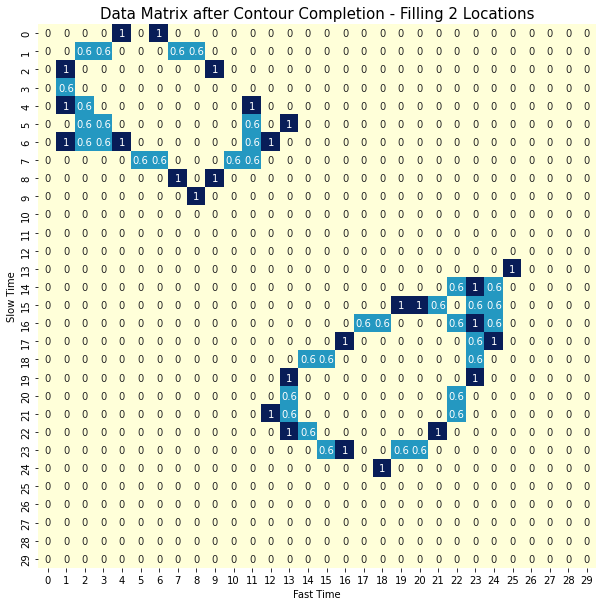

In [ ]:
#Contour completion with 2 boxes
#Newly filled values are indicated with 0.6
contour_filled_1 = fill_2_loc(noise_filtered_2,0.6)

plt.figure(figsize=(10,10))
sns.heatmap(contour_filled_1, annot=True, cbar=False, cmap="YlGnBu")
plt.title("Data Matrix after Contour Completion - Filling 2 Locations", fontsize= 15)
plt.xlabel("Fast Time") 
plt.ylabel('Slow Time')
plt.show()


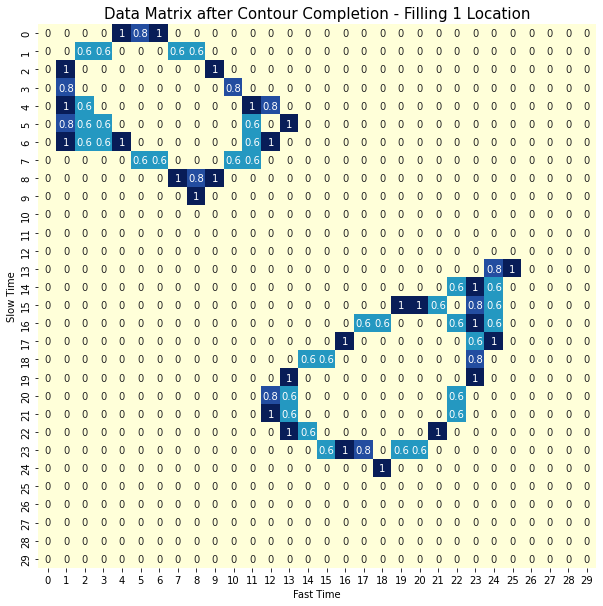

In [ ]:
#Contour completion with 1 box
#Newly filled values are indicated wit 0.8
contour_filled_2 = fill_1_loc(contour_filled_1,0.8)

plt.figure(figsize=(10,10))
sns.heatmap(contour_filled_2, annot=True, cbar=False, cmap="YlGnBu")
plt.title("Data Matrix after Contour Completion - Filling 1 Location", fontsize= 15)
plt.xlabel("Fast Time") 
plt.ylabel('Slow Time')
plt.show()

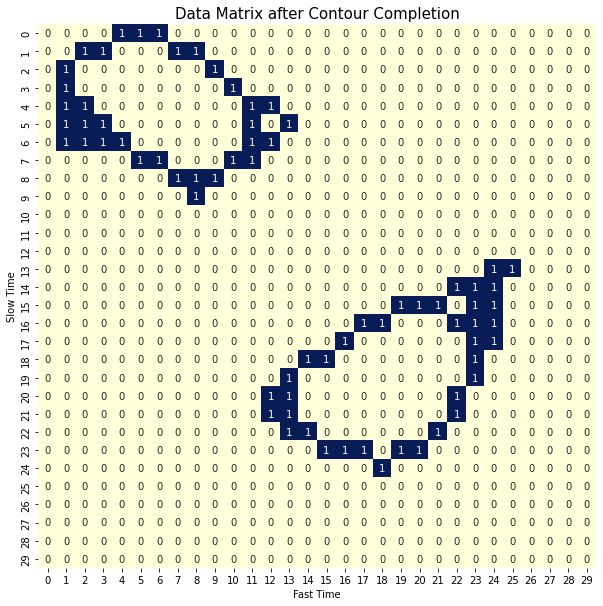

In [ ]:
#Obtaining the contours of the clouds
contour_completed = np.where(contour_filled_2>0,1,0)

plt.figure(figsize=(10,10))
sns.heatmap(contour_completed, annot=True, cbar=False, cmap="YlGnBu")
plt.title("Data Matrix after Contour Completion", fontsize= 15)
plt.xlabel("Fast Time") 
plt.ylabel('Slow Time')
plt.show()

# **Filling the Boundary**

locations inside the contours are filled using *floodfill* algorithm

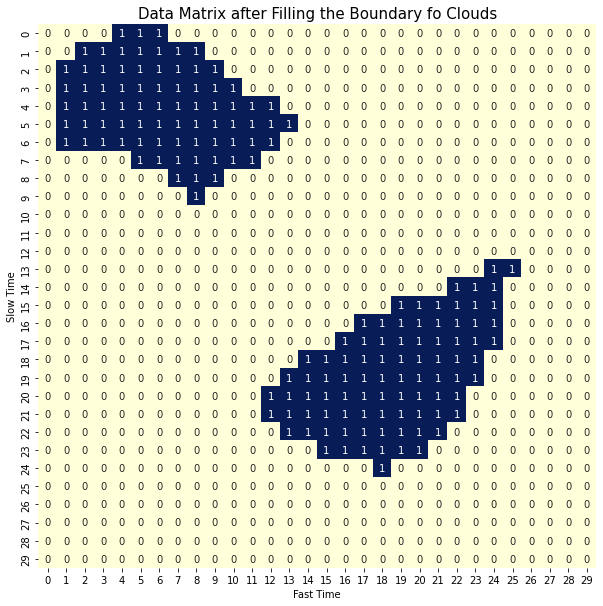

In [ ]:
#Filling the contours and adding information about other objects
filled_data_inv=cv2.floodFill(np.uint8(contour_completed), None, seedPoint=(0,0), newVal=2)

filled_data = np.where(np.array(filled_data_inv)[1]==2,0,1)

filled_data_f = np.float32(filled_data)


plt.figure(figsize=(10,10))
sns.heatmap(filled_data_f, annot=True, cbar=False, cmap="YlGnBu")
plt.title("Data Matrix after Filling the Boundary fo Clouds", fontsize= 15)
plt.xlabel("Fast Time") 
plt.ylabel('Slow Time')
plt.show()




# **Noise Filtering Final Stage and Encoding Targets**

3x3 filter with threshold of 1 is used to filter out any unfiltered noise.

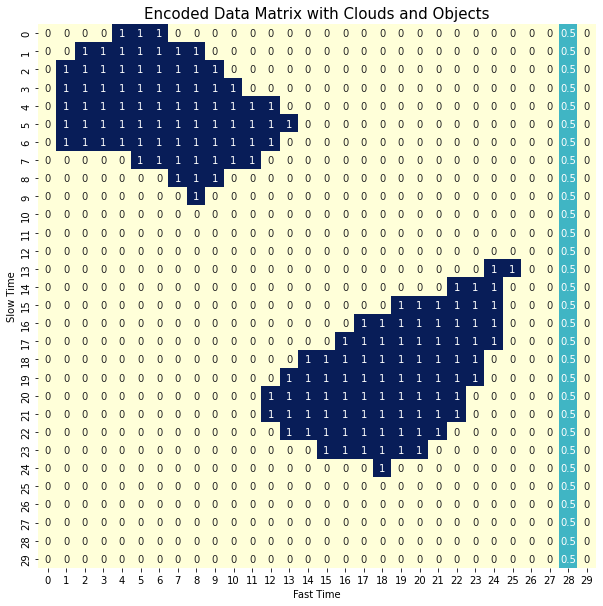

In [ ]:
#Noise filtering with a 3x3 filter with a threshold of 1
output = noise_filter(filled_data_f,3,1)

#Encoding objects with 0.5
for i in range(len(targets)):
    if (targets[i]==1):
        output[:,i]=0.5


plt.figure(figsize=(10,10))
sns.heatmap(output, annot=True, cbar=False, cmap="YlGnBu")
plt.title("Encoded Data Matrix with Clouds and Objects", fontsize= 15)
plt.xlabel("Fast Time") 
plt.ylabel('Slow Time')
plt.show()

# **Calculating Distance to Targets**
$ \Delta R\ =\ \frac{cT_s}{2}\ =\ \frac{3*10^8}{2*54000}\ = 2777.778\ m$

Therefore, each range slot represnts a distance of $2.778\ km$ in the space.

Disntace ($d$) to the target detected on $n^{th}$ range slot is calculated using follwing equation,

$d\ =\ (n+1)ΔR$ 

# **Calculating Azimuth Angle**
Azimuth angle is calculated from follwing equation.

$Azimuth\ Angle\ =\ (n + \frac{m-n}{2})\frac{𝑅𝑎𝑑𝑎𝑟\ 𝑅𝑜𝑡𝑎𝑡𝑖𝑜𝑛\ 𝑆𝑝𝑒𝑒𝑑}{𝑃𝑢𝑙𝑠𝑒\ 𝑅𝑒𝑝𝑖𝑡𝑖𝑜𝑛\ 𝐹𝑟𝑒𝑞𝑢𝑒𝑛𝑐𝑦} = (\frac{n+m}{2})\frac{12*360}{60*1800} =\ (\frac{n+m}{2})*0.04$

First pulse where the object is detected = $n$<br>
Last pulse where the object is detected = $m$

Pulse numbers are indexed from 0-29. Therefore $n$ amd $m$ calculated by adding $1$ to the pulse number.

In [ ]:
delta_R = 2777.778

if ((len(target_loc))==0):
  print("No targets detected")

else:
  for i in range (len(target_loc)):
    distance = (target_loc[i]+1)*delta_R

    azimuth = (n_vals[i] + (m_vals[i]-n_vals[i])/2)*0.04
    print ('Distance to the target %d is %.3f km at an azimuth angle of %.3f degrees'%(i+1,(distance/1000),azimuth))


Distance to the target 1 is 80.556 km at an azimuth angle of 0.640 degrees
